In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error as mae
import time
import numpy as np

In [50]:
#loading the preprocessed data
price=pd.read_csv("price.csv")
price=pd.DataFrame(price.Close)
price

Close
0    -0.910967
1    -0.860903
2    -0.865971
3    -0.929141
4    -0.931893
...        ...
1004 -0.155720
1005 -0.024705
1006 -0.145497
1007 -0.249820
1008 -0.229855

[1009 rows x 1 columns]

In [51]:
#Dividing the data into training and testing sets and specifying the window width for the analysis(sliding window approach)

def prepare_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

lookback = 20
x_train, y_train, x_test, y_test = prepare_data(price, lookback)

In [52]:
#converting training and testing sets to torch tensors

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [53]:
#Defining the LSTM and GRU model classes
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    #forward propagation
    def forward(self, x):
        initial_hidden_state = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad=True)
        initial_cell_state = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad=True)
        lstm_output, (final_hidden_state, final_cell_state) = self.lstm(x, (initial_hidden_state.detach(), initial_cell_state.detach()))
        output = self.fc(lstm_output[:, -1, :])
        return output
    
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        initial_hidden_state = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad=True)
        output, (final_hidden_state)=self.gru(x, (initial_hidden_state.detach()))
        output=self.fc(output[:, -1, :])
        return output
    
#RMSE Function
def calculate_rmse(y_true, y_pred):
    
    #calculating the Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse

In [54]:
#loading the trained models
lstm=torch.load('lstm_model.pth')
lstm.load_state_dict(torch.load('lstm_state_dict.pth'))

gru=torch.load('gru_model.pth')
gru.load_state_dict(torch.load('gru_state_dict.pth'))

<All keys matched successfully>

## Testing LSTM model

In [61]:
#Using the trained lstm model to make predictions on the test data
y_test_pred=lstm(x_test)

#Printing the RMSE and MAE
rmse_lstm=calculate_rmse(y_test_lstm.detach().numpy(),y_test_pred.detach().numpy())
mae_lstm=mae(y_test_lstm.detach().numpy(),y_test_pred.detach().numpy())
print(f"Root Mean Square Error:{rmse_lstm}")
print(f"Mean Absolute Error:{mae_lstm}")

Root Mean Square Error:0.260686993598938
Mean Absolute Error:0.19301216304302216


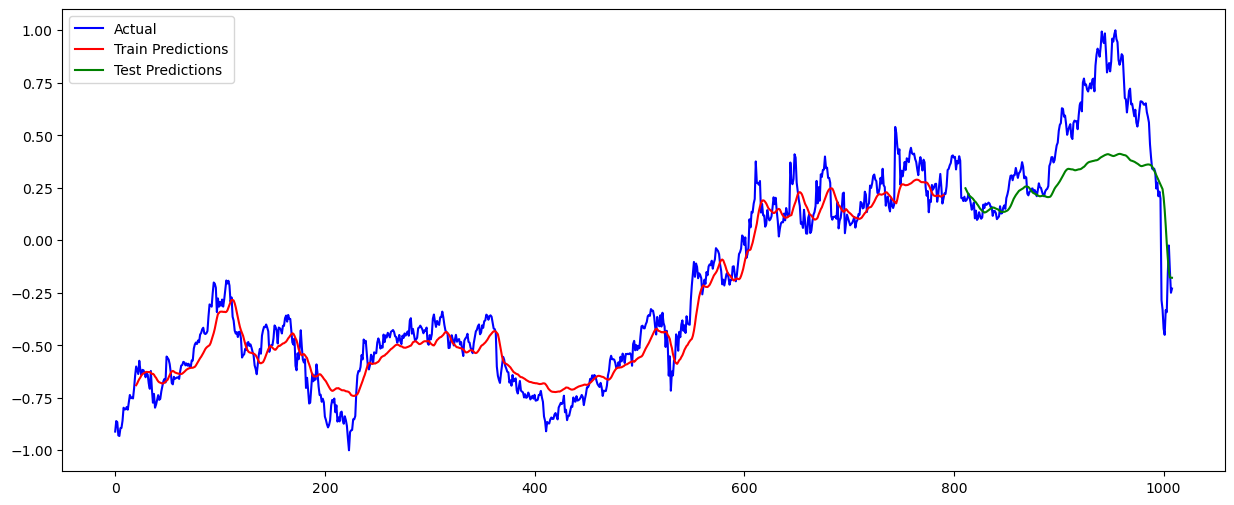

In [56]:
# Producing the Actual vs Predicted graph shown in paper for LSTM model

train_size=len(x_train)
plt.figure(figsize=(15,6))
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(price) * np.nan
    train_plot[lookback:train_size]= lstm(x_train)[:train_size-lookback]
    test_plot = np.ones_like(price) * np.nan
    test_plot[train_size+lookback:len(price)] = lstm(x_test)[:]
# plot
plt.plot(price, c='b',label="Actual")
plt.plot(train_plot, c='r',label="Train Predictions")
plt.plot(test_plot, c='g',label="Test Predictions")
plt.legend(loc='upper left')


## Testing GRU Model

In [62]:
#Using the trained lstm model to make predictions on the test data
y_test_pred = gru(x_test)

#Printing the RMSE and MAE
rmse_gru=calculate_rmse(y_test_gru.detach().numpy(),y_test_pred.detach().numpy())
mae_gru=mae(y_test_gru.detach().numpy(),y_test_pred.detach().numpy())
print(f"Root Mean Square Error:{rmse_gru}")
print(f"Mean Absolute Error:{mae_gru}")

Root Mean Square Error:0.10136663168668747
Mean Absolute Error:0.07150472700595856


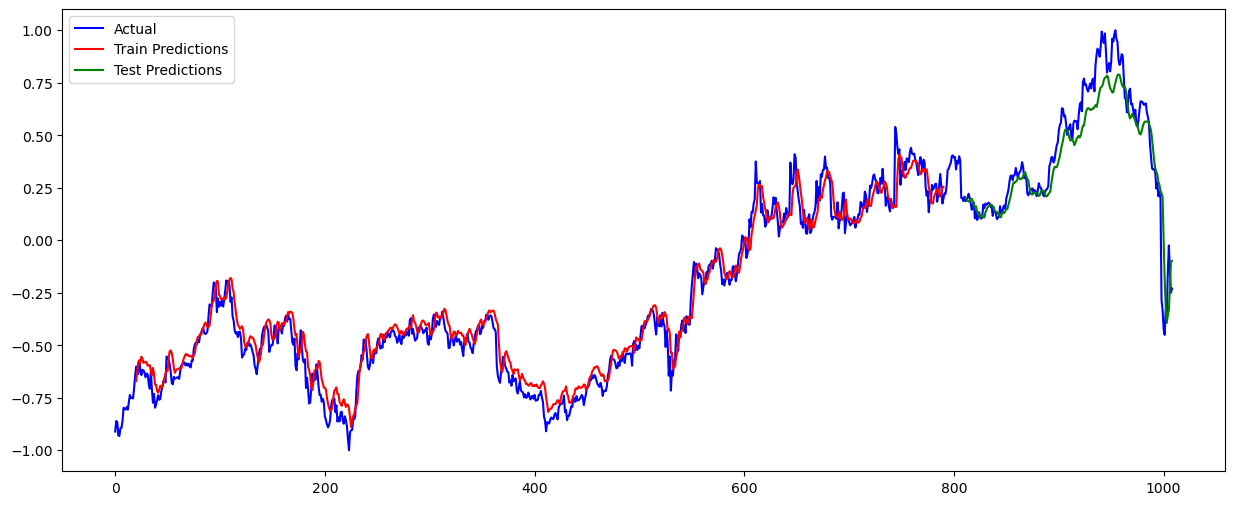

In [63]:
# Producing the Actual vs Predicted graph shown in paper for GRU model


train_size=len(x_train)
plt.figure(figsize=(15,6))
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(price) * np.nan
    train_plot[lookback:train_size]= gru(x_train)[:train_size-lookback]
    test_plot = np.ones_like(price) * np.nan
    test_plot[train_size+lookback:len(price)] = gru(x_test)[:]
# plot
plt.plot(price, c='b',label="Actual")
plt.plot(train_plot, c='r',label="Train Predictions")
plt.plot(test_plot, c='g',label="Test Predictions")
plt.legend(loc="upper left")